In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import scipy

In [88]:
train = pd.read_csv("./data/first_clean/train_gearbox.csv", sep=",")
test = pd.read_csv("./data/first_clean/test_gearbox.csv", sep=",")

In [89]:
reg_target_name = "RUL (Target)"
class_target_name = "Failure (Target)"
drop_cols = [reg_target_name, class_target_name, "Turbine_ID", "Timestamp", "Unnamed: 0"]

In [101]:
def fill_nans_w_method(train, test, methods: list) -> tuple[dict, dict, dict, dict]:

    X_train_dict = {}
    y_train_dict = {}
    X_test_dict = {}
    y_test_dict = {}

    # train samplen, um Trainings-Zeit zu verkürzen
    train_frac = 0.1

    for method in methods:
        if method == "median":
            filled_train = train.fillna(train.median()).sample(frac=train_frac)
            filled_test = test.fillna(test.median()).sample(frac=1)
            X_train_dict[method] = filled_train.drop(columns=drop_cols)
            y_train_dict[method] = filled_train[class_target_name]
            X_test_dict[method] = filled_test.drop(columns=drop_cols)
            y_test_dict[method] = filled_test[class_target_name]
        else:
            filled_train = train.fillna(method=method).sample(frac=train_frac)
            filled_test = test.fillna(method=method).sample(frac=1)
            X_train_dict[method] = filled_train.drop(columns=drop_cols)
            y_train_dict[method] = filled_train[class_target_name]
            X_test_dict[method] = filled_test.drop(columns=drop_cols)
            y_test_dict[method] = filled_test[class_target_name]

    return X_train_dict, y_train_dict, X_test_dict, y_test_dict

In [102]:

X_compounded = {}
y_compounded = {}

X_test_compounded = {}
y_test_compounded = {}

fill_methods = ["ffill", "bfill", "median"]

X_compounded, y_compounded, X_test_compounded, y_test_compounded = fill_nans_w_method(train, test, fill_methods)

In [103]:
def train_run(X, y, X_test, y_test, model):

    clf = model
    clf.fit(X, y)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X)
    f1_train = f1_score(y, y_train_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    scores = {
        "f1_train": f1_train,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

    return scores

In [125]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [136]:
def train_runs(X_compounded, y_compounded, X_test_compounded, y_test_compounded):
    
    best_scores = []

    for fe_type in fill_methods:
        X_train = X_compounded[fe_type]
        X_test = X_test_compounded[fe_type]
        y_train = y_compounded[fe_type]
        y_test = y_test_compounded[fe_type]

        base_estimator = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
        param_grid = {
            "max_depth": scipy.stats.randint(5, 60),
            "min_samples_leaf": scipy.stats.randint(1, 1000),
            "class_weight": ["balanced", None], 
            "criterion": ["gini", "entropy", "log_loss"],
        }
        sh = RandomizedSearchCV(base_estimator, param_grid, scoring="f1").fit(X_train, y_train)
        clf = sh.best_estimator_
        report(sh.cv_results_)

        scores = train_run(X_train, y_train, X_test, y_test, model=clf)

        best_scores.append({
            "type": fe_type,  "f1_train": scores["f1_train"], "f1": scores["f1"], 
            "precision": scores["precision"], "recall": scores["recall"], "clf": clf})
    
    return best_scores

In [137]:
# %run ./utility/model_loader.py -i

In [138]:
best_scores = train_runs(X_compounded, y_compounded, X_test_compounded, y_test_compounded)

Model with rank: 1
Mean validation score: 0.280 (std: 0.085)
Parameters: {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 36, 'min_samples_leaf': 98}

Model with rank: 2
Mean validation score: 0.225 (std: 0.006)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 54, 'min_samples_leaf': 513}

Model with rank: 3
Mean validation score: 0.213 (std: 0.014)
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 635}

Model with rank: 1
Mean validation score: 0.251 (std: 0.022)
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 487}

Model with rank: 2
Mean validation score: 0.249 (std: 0.015)
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 428}

Model with rank: 3
Mean validation score: 0.242 (std: 0.016)
Parameters: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 13, 'min_samples_leaf': 52

In [139]:
best_scores

[{'type': 'ffill',
  'f1_train': 0.42328042328042326,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'clf': DecisionTreeClassifier(ccp_alpha=0.001, criterion='log_loss', max_depth=36,
                         min_samples_leaf=98, random_state=0)},
 {'type': 'bfill',
  'f1_train': 0.25207452638171285,
  'f1': 0.03937854573769884,
  'precision': 0.028956265677827463,
  'recall': 0.061522419186652764,
  'clf': DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced',
                         criterion='entropy', max_depth=15, min_samples_leaf=487,
                         random_state=0)},
 {'type': 'median',
  'f1_train': 0.5842550422901757,
  'f1': 0.008599021034528377,
  'precision': 0.01002004008016032,
  'recall': 0.007530992932452786,
  'clf': DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced',
                         criterion='log_loss', max_depth=37, random_state=0)}]

In [52]:
y_pred = best_scores[0]["clf"].predict(X_compounded["ffill"])

(array([31931.,     0.,   990.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

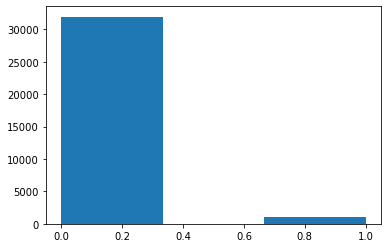

In [53]:
plt.hist(y_pred, bins=3)

(array([32059.,     0.,   862.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

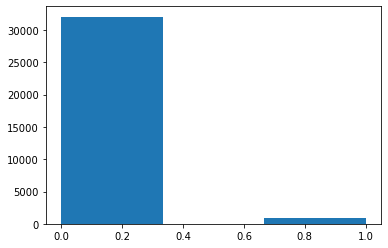

In [56]:
plt.hist(y_train, bins=3)

In [97]:
tree = best_scores[0]["clf"]
path = tree.cost_complexity_pruning_path(X_compounded["ffill"], y_compounded["ffill"])

In [98]:
alphas=path["ccp_alphas"]

In [100]:
len(alphas)

770